In [1]:
import os
import glob
os.chdir("/usr/src/app")

In [2]:
import luigi
from models.market_price_model.tasks import PricesGeotiff, PriceToGeoJSON, MergePriceAccessbilityRaster, PricesGeotiffHighRes 

import ipywidgets as widgets
import datetime
from luigi import Task
from luigi.date_interval import Custom as CustomDateInterval
from luigi.parameter import DateIntervalParameter                                                                                                           

In [3]:
# use interactive, not interact to easily access the input value!

year_month = widgets.Dropdown(
    options=["2018-01", "2018-02",
            "2018-03", "2018-04", "2018-05", 
             "2018-06"],
    description='Date',
    disabled=False,
)


def input_val(x):
    return str(x)

yr_wd=widgets.interactive(input_val, x=year_month)
display(yr_wd)

band_wd=widgets.Dropdown(
    options=['Bread and Cereal','Pulses and Vegetable',
            'Sugar, jam, honey, chocolate and candy',
            'Fruit','Meat',
            'Milk, Cheese and Egg'],
    description='Commodity:',
    disabled=False,
)
display(band_wd)

scn_wd = widgets.Dropdown(
    options=['low', 'high', 'normal'],
    description='Rainfall scenario:',
    disabled=False,
)
display(scn_wd)

interactive(children=(Dropdown(description='Date', options=('2018-01', '2018-02', '2018-03', '2018-04', '2018-…

Dropdown(description='Commodity:', options=('Bread and Cereal', 'Pulses and Vegetable', 'Sugar, jam, honey, ch…

Dropdown(description='Rainfall scenario:', options=('low', 'high', 'normal'), value='low')

In [4]:
raster_band_dict=dict()
def Convert(tup, di): 
    for i, k in enumerate(tup): 
        di.setdefault(k, []).append(i+1)     
    return di

In [5]:
band_dictionary = Convert(band_wd.options, raster_band_dict)
del raster_band_dict

In [6]:
eth_geo_file = {
    "coordinates": [[[36.357226629663501, 14.272502682267801],[37.2970544510355, 14.6772882598167],[37.719862777828297, 15.0348782791802],[38.406926308866502, 14.8050668691039],[40.0981596160373, 14.4726873923002],[41.630839800661001, 13.4982974690825],[42.529307495095502, 12.365084475553299],[41.921520525330997, 11.1750924233907],[42.925690301463703, 11.1750924233907],[43.004966862737298, 10.578226842108799],[44.141264240992797, 9.224600687836],[47.033937477102299, 8.239013541804599],[48.343304299598302, 8.21360385046173],[45.151070168399599, 4.73902070129281],[43.621706074706402, 4.59611835261279],[42.379097748580598, 3.85735258666634],[41.255970992274698, 3.73813341072871],[40.730252085067598, 4.02423122213936],[39.631021642725599, 3.30881385146286],[38.8185469679511, 3.30881385146286],[38.029968607140503, 3.42808897514322],[36.906841850834503, 4.19107567031119],[35.9031966643484, 4.28639946386431],[35.568648268853003, 5.04853993824516],[35.042929361645903, 5.23894050051229],[34.732277280114502, 6.38005314679845],[32.772779535070001, 7.87384558608177],[33.035638988673597, 8.583349846796411],[33.872009977412098, 8.65422922148511],[34.134869431015602, 10.656535086660901],[36.357226629663501, 14.272502682267801]]],
    "type": "Polygon",
}

In [7]:
timepoint = '2018'+'-'+'01-01-'+'2018'+'-'+'06-01'

In [8]:
PricesGeotiff = PricesGeotiff(
    time=DateIntervalParameter().parse(timepoint),
    rainfall_scenario=scn_wd.value,
    country_level= "Ethiopia" ,
    geography=  eth_geo_file , 
)

In [9]:
Price_Raster = MergePriceAccessbilityRaster(
    time=DateIntervalParameter().parse(timepoint),
    rainfall_scenario=scn_wd.value,
    country_level= "Ethiopia" ,
    geography=  eth_geo_file , 
)

In [10]:
Price_Major_Markets = PricesGeotiffHighRes(
    time=DateIntervalParameter().parse(timepoint),
    rainfall_scenario=scn_wd.value,
    country_level= "Ethiopia" ,
    geography=  eth_geo_file , 
)

In [17]:
luigi.build([PricesGeotiff, Price_Major_Markets, Price_Raster], local_scheduler=True, no_lock=True)

[2020-05-31 04:00:41,214] INFO [luigi:63] logging already configured
[2020-05-31 04:00:41,223] INFO [luigi-interface:595] Informed scheduler that task   models.market_price_model.tasks.PricesGeotiff_admin2_Ethiopia___coordinates____896bc895fa   has status   DONE
[2020-05-31 04:00:41,226] INFO [luigi-interface:595] Informed scheduler that task   models.market_price_model.tasks.PricesGeotiffHighRes_admin2_Ethiopia___coordinates____896bc895fa   has status   DONE
[2020-05-31 04:00:41,230] INFO [luigi-interface:595] Informed scheduler that task   models.market_price_model.tasks.MergePriceAccessbilityRaster_admin2_Ethiopia___coordinates____896bc895fa   has status   DONE
[2020-05-31 04:00:41,231] INFO [luigi-interface:172] Done scheduling tasks
[2020-05-31 04:00:41,232] INFO [luigi-interface:1182] Running Worker with 1 processes
[2020-05-31 04:00:41,234] INFO [luigi-interface:493] Worker Worker(salt=355587643, workers=1, host=bbadabffe1a5, username=root, pid=76) was stopped. Shutting down Kee

True

In [12]:
def plot_raster(raster_tiff, plot_title="", scale='normal', band=1):
    """
    raster_tiff: path to the raster .tiff file
    """
    
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import gdal
    import numpy as np
    
    srcfile=gdal.Open(raster_tiff)
    src_band=srcfile.GetRasterBand(band).ReadAsArray().astype(np.float)
    ref_proj = srcfile.GetProjection()
    ref_geotrans = srcfile.GetGeoTransform()
    nrows = srcfile.RasterYSize
    ncols = srcfile.RasterXSize
    no_data_val = srcfile.GetRasterBand(1).GetNoDataValue()
    ulx, xres, xskew, uly, yskew, yres  = ref_geotrans
    lrx = ulx + (ncols * xres)
    lry = uly + (nrows * yres)
    img_extent = (ulx, lrx, lry, uly)
    srcfile = None

    src_band[src_band==no_data_val] = np.nan
    
    fig = plt.figure(figsize=(14, 14))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cmap = mpl.cm.YlGnBu #terrain
    
    cmap.set_bad('#e5e6e8')
    if scale=='log':
        h = ax.imshow(src_band, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), 
                      cmap=cmap,norm=mpl.colors.LogNorm())
    else: 
        h = ax.imshow(src_band, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), 
                      cmap=cmap)
    
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    plt.colorbar(h, cax=ax_cb)
    
    ax.set_title(plot_title + ' ('+scale+')' , fontsize=24)

In [13]:
for key,value in band_dictionary.items():
    if key ==band_wd.value:  
        commodity_name = band_wd.value  

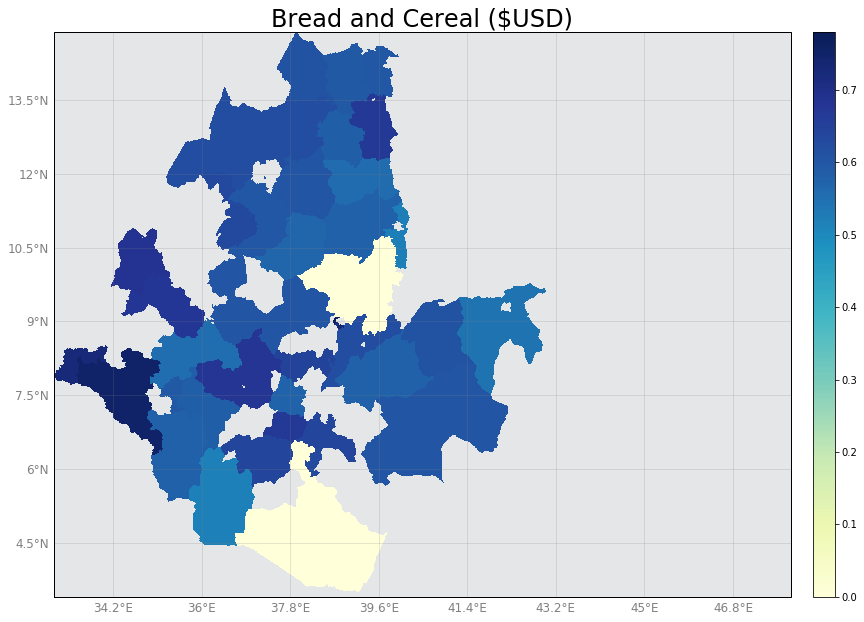

In [14]:
# find the output tiffs, and pass the first to plot
target = PricesGeotiff.output().path
price_output = glob.glob(target + '/*.tiff')[0]
     
plot_raster(price_output, commodity_name , scale='$USD', band=band_dictionary[band_wd.value][0])

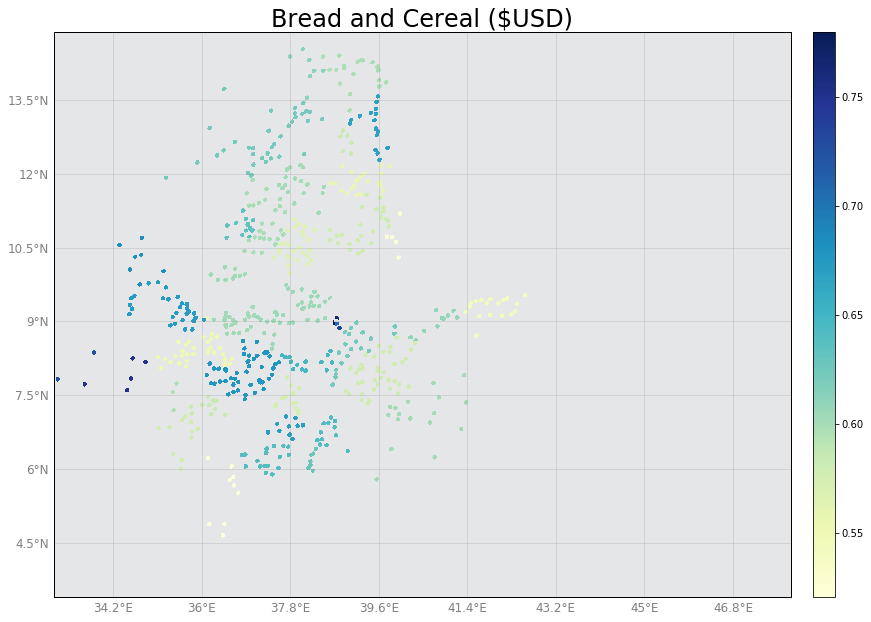

In [15]:
# Find the output tiffs, and pass the first to plot
target_major_markets = Price_Major_Markets.output().path
price_major_output = glob.glob(target_major_markets + '/*.tiff')[0]
     
plot_raster(price_major_output, commodity_name , scale='$USD', band=band_dictionary[band_wd.value][0])

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


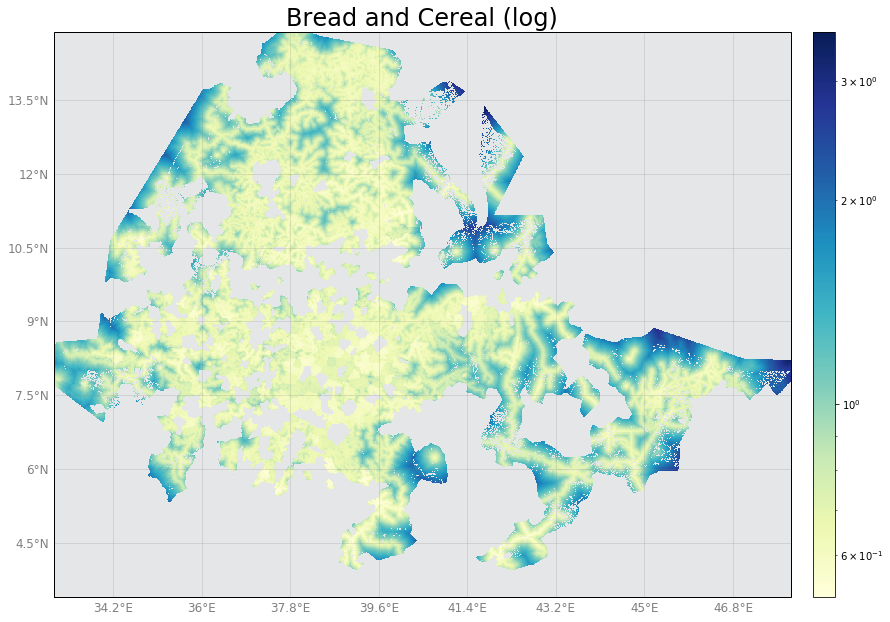

In [16]:
# Price raster
target_raster = Price_Raster.output().path
price_raster = glob.glob(target_raster + '/*.tiff')[0]
     
plot_raster(price_raster, commodity_name , scale='log', band=band_dictionary[band_wd.value][0])